In [1]:
import os
import sys
import operator
from pathlib import Path
from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_teddynote import logging

# 프로젝트 루트를 Python 경로에 추가 (rag 모듈 import를 위해 필요)
project_root = Path().resolve().parent if Path().resolve().name == "LangGraph" else Path().resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✅ 프로젝트 루트 추가됨: {project_root}")

✅ 프로젝트 루트 추가됨: C:\Users\rkddn\YAI-NLP


In [2]:
#LangSmith 추적 설정
load_dotenv()
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_PROJECT"] = "LangSmith_YAI"
# os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

# from langchain_teddynote import logging

# logging.langsmith("YAI-NLP-Project")

#추적 안 하고 싶을 때
#logging.langsmith("YAI-NLP-Project", set_enable=False)

True

In [3]:
from rag.pdf import PDFRetrievalChain

hf_token = os.getenv("HF_API_KEY")
if hf_token:
    os.environ["HF_API_KEY"] = hf_token
else:
    print("⚠️ 경고: HF_API_KEY이 없습니다.")


print("🚀 Hugging Face 기반 체인 생성 시작...")
# 이렇게 써도 프로젝트 data/testdata.pdf 로 해석됨
pdf = PDFRetrievalChain(["nlp.pdf"]).create_chain()
print("✅ 체인 생성 완료!")

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

🚀 Hugging Face 기반 체인 생성 시작...


Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats


✅ 체인 생성 완료!


In [4]:
search_result = pdf.retriever.invoke("닷-프로덕트 어텐션에 대해 설명해주세요")
search_result

[Document(id='1dc552cb-ed0a-4ea4-8b04-d8e448836728', metadata={'source': 'nlp.pdf', 'file_path': 'nlp.pdf', 'page': 1, 'total_pages': 7, 'Creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36', 'Producer': 'Skia/PDF m118', 'CreationDate': "D:20231103094424+00'00'", 'ModDate': "D:20231103094424+00'00'"}, page_content='3. 닷-프로덕트 어텐션(Dot-Product Attention)\n어텐션은 다양한 종류가 있는데 그 중에서도 가장 수식적으로 이해하기 쉽게 수식을 적용한 닷-프로덕트 어텐션(Dot-Product\nAttention)을 통해 어텐션을 이해해봅시다. seq2seq에서 사용되는 어텐션 중에서 닷-프로덕트 어텐션과 다른 어텐션의 차이는 주로\n중간 수식의 차이로 메커니즘 자체는 거의 유사합니다.'),
 Document(id='862438eb-f2bd-4215-b0fc-c3f22025bd4b', metadata={'source': 'nlp.pdf', 'file_path': 'nlp.pdf', 'page': 6, 'total_pages': 7, 'Creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36', 'Producer': 'Skia/PDF m118', 'CreationDate': "D:20231103094424+00'00'", 'ModDate': "D:20231103094424+00'00'"}, page_content='지

In [5]:
# answer = pdf_chain.invoke(
#     {
#         "question": "닷-프로덕트 어텐션에 대해 설명해주세요. 반드시 한글로 설명하세요요",
#         "context": search_result,
#         "chat_history": [],
#     }
# )
# print(answer)

In [6]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# 에이전트 상태를 정의하는 타입 딕셔너리, 메시지 시퀀스를 관리하고 추가 동작 정의
class AgentState(TypedDict):
    # add_messages reducer 함수를 사용하여 메시지 시퀀스를 관리
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [7]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    #policy: Annotated[str, "Policy"] #누적됨
    question: Annotated[str, "Question"]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    messages: Annotated[list, add_messages] #메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]

    """
    context 구성요소
    1. 챗봇 대화 기록
    2. 웹 검색 결과
    3. 시스템 프롬프트
    4. [POLICY]
    5. 사용자 질문
    6. 최근에 retrieve 한 내용


    context내에서 처리 or retrieve?
    -> 프롬프트 내에 연관성이 있는 맥락이 있는지 서치하는 LLM 모델 필요할 듯
    """
    

<h3>노드 정의</h3>

Relevance 체크용 모델

In [8]:
from huggingface_hub import login
login(token=os.getenv("HF_API_KEY"))

In [9]:
#일단 Relevance용 모델 정의
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

hf_llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",
    task="text-generation",
    temperature=0.0,
    max_new_tokens=512,
)

chat_hf = ChatHuggingFace(llm=hf_llm)

In [10]:
import json
import re
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs

def retrieve_or_not(state: GraphState) -> str:
    """
    사용자 질문에 대해 문서 검색(retrieve)이 필요한지 판단.
    - 검색 불필요 → "not retrieve" → llm_answer로 직행
    - 검색 필요 → "retrieve" → retrieve 노드로 이동
    Hugging Face Meta Llama(chat_hf) 사용.
    """
    question = state["question"]
    if not question:
        return "not retrieve"

    prompt = f"""
                다음 사용자 질문에 답하려면 **문서/벡터DB 검색(retrieve)**이 필요한지 판단하세요.

                판단 기준:
                - 인사, 감정, 단순 대화("안녕", "고마워", "뭐해" 등), 잡담 → 검색 불필요
                - 문서에 있을 법한 전문 지식 질문 → 검색 필요
                - 최신 정보/뉴스(노벨상, 날짜별 사건 등) → 검색 필요

                질문: {question}

                *반드시 아래 JSON 형식으로만 답하세요. 다른 텍스트 없이 JSON만 출력.
                {{"need_retrieve": "yes"}} 또는 {{"need_retrieve": "no"}}
                """

    try:
        response = chat_hf.invoke(prompt)
        text = (response.content or "").strip()
        match = re.search(r"\{[^{}]*\"need_retrieve\"[^{}]*\}", text)
        if match:
            data = json.loads(match.group(0))
            need = (data.get("need_retrieve") or "no").lower()
            if need in ("yes", "true", "1"):
                print("==============retrieve Node============")
                return "retrieve"
        print("==============go to llm_answer============")
        return "not retrieve"
    except Exception:
        return "retrieve"


def upload_to_vectorDB(state: GraphState) -> bool:
    if "Search 함수에서 찾은 내용을 -> 벡터DB에 업로드 성공":
        return True
    else:
        return False

def multiturn_chat_to_vectorDB(state: GraphState) -> bool:
    if "컨텍스트가 너무 길어져서 -> 벡터DB에 업로드 성공":
        return True
    else:
        return False
    
"""===========노드 정의=========="""



def retrieve(state: GraphState) -> GraphState:
    latest_question = state["question"]
    retrieved_docs = pdf_retriever.invoke(latest_question)
    formatted_docs = format_docs(retrieved_docs)
    return GraphState(context=formatted_docs)
    #same as return {"context": formatted_docs}

def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    
    # 체인을 호출하여 답변을 생성합니다.
    chat_history = state.get("messages", [])
    
    try:
        response = pdf_chain.invoke(
            {
                "question": latest_question,
                "context": context,
                "chat_history": chat_history,
            }
        )
    except Exception as e:
        # BadRequestError 등 상세한 에러 정보 출력
        print("=" * 80)
        print("❌ LLM 호출 중 에러 발생!")
        print("=" * 80)
        print(f"에러 타입: {type(e).__name__}")
        print(f"에러 메시지: {str(e)}")
        
        # API 응답 본문 확인 (가장 중요!)
        if hasattr(e, 'response'):
            response = e.response
            print(f"\nAPI 응답 객체: {response}")
            try:
                # 응답 본문 읽기 시도
                if hasattr(response, 'text'):
                    print(f"API 응답 본문 (text): {response.text}")
                elif hasattr(response, 'content'):
                    print(f"API 응답 본문 (content): {response.content}")
                if hasattr(response, 'json'):
                    try:
                        error_json = response.json()
                        print(f"API 응답 본문 (JSON): {json.dumps(error_json, indent=2, ensure_ascii=False)}")
                    except:
                        pass
            except Exception as resp_e:
                print(f"응답 본문 읽기 실패: {resp_e}")
        
        # 기타 속성 확인
        if hasattr(e, 'status_code'):
            print(f"HTTP 상태 코드: {e.status_code}")
        if hasattr(e, 'request_id'):
            print(f"Request ID: {e.request_id}")
        
        # 입력 데이터 정보 (디버깅용)
        context_str = str(context)
        print("\n입력 데이터 정보:")
        print(f"  - question 길이: {len(latest_question)} 문자")
        print(f"  - context 길이: {len(context_str)} 문자")
        # 대략적인 토큰 수 추정 (한글 1자 ≈ 1-2 토큰, 영어 4자 ≈ 1 토큰)
        estimated_tokens = len(context_str) // 2  # 보수적으로 추정
        print(f"  - context 추정 토큰 수: 약 {estimated_tokens:,} 토큰")
        print(f"  - chat_history 타입: {type(chat_history)}, 길이: {len(chat_history) if isinstance(chat_history, list) else 'N/A'}")
        print(f"\n  - context 미리보기 (처음 200자): {context_str[:200]}...")
        print("=" * 80)
        
        # 에러를 다시 발생시켜서 그래프가 실패 처리되도록
        raise
    
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )

Relevance Check Node (question-retrieve)

In [11]:
import json
import re

def relevance_check(state: GraphState) -> GraphState:
    prompt = f"""
You are a grader assessing whether a retrieved document is relevant to the given question.
Return ONLY valid JSON like: {{"score": "yes"}} or {{"score": "no"}}.

Question:
{state["question"]}

Retrieved document:
{state["context"]}
""".strip()

    # HF 모델 호출
    response = chat_hf.invoke(prompt)

    # ChatHuggingFace는 보통 response.content에 텍스트가 들어있음
    text = response.content.strip()

    # JSON만 추출 (모델이 앞뒤에 텍스트를 섞는 경우 대비)
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if match:
        text = match.group(0)

    try:
        data = json.loads(text)
        score = data.get("score", "no").lower()
    except Exception:
        score = "no"

    if score not in ["yes", "no"]:
        score = "no"

    print("==== [RELEVANCE CHECK] ====")
    print(score)

    return {"relevance": score}

def is_relevant(state: GraphState) -> str:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

Web Search Node

In [20]:
from langchain_teddynote.tools.tavily import TavilySearch
import re

MAX_TOKENS_PER_DOC = 1000
CHARS_PER_TOKEN_EST = 1.5  # 한글/영어 혼합 시 대략 1.5자당 1토큰
MAX_CHARS_PER_DOC = int(MAX_TOKENS_PER_DOC * CHARS_PER_TOKEN_EST)  # 약 1500자

def _parse_document(doc_str: str) -> dict:
    """<document> 문자열에서 title, url, content, raw 추출."""
    title = re.search(r"<title>(.*?)</title>", doc_str, re.DOTALL)
    url = re.search(r"<url>(.*?)</url>", doc_str, re.DOTALL)
    content = re.search(r"<content>(.*?)</content>", doc_str, re.DOTALL)
    raw = re.search(r"<raw>(.*?)</raw>", doc_str, re.DOTALL)
    return {
        "title": title.group(1).strip() if title else "",
        "url": url.group(1).strip() if url else "",
        "content": content.group(1).strip() if content else "",
        "raw": raw.group(1).strip() if raw else "",
    }

def _summarize_content_and_raw(parsed: dict, llm, max_chars: int = MAX_CHARS_PER_DOC) -> str:
    """<content>와 <raw> 내용을 LLM으로 요약하여 한 덩어리 텍스트로 반환 (최대 max_chars자)."""
    content = parsed["content"] or ""
    raw = parsed["raw"] or ""
    combined = content
    if raw:
        combined = combined + "\n\n[원문 일부]\n" + raw
    if len(combined.strip()) == 0:
        return "(내용 없음)"
    prompt = f"""아래 텍스트를 핵심만 남겨 {max_chars}자 이내로 요약해주세요. 요약은 한글로 작성하고, 불필요한 반복은 제거하세요. 요약만 출력하세요.

---
{combined[:8000]}
---"""
    try:
        response = llm.invoke(prompt)
        text = (response.content if hasattr(response, "content") else str(response)).strip()
        return text[:max_chars] if len(text) > max_chars else text
    except Exception as e:
        return (content[:max_chars] + "...") if len(content) > max_chars else (content or "(요약 실패)")

def _build_document(parsed: dict, summarized_body: str) -> str:
    """parsed의 title, url을 유지하고 content/raw 자리를 summarized_body 하나로 채워 <document> 문자열 재구성."""
    title = parsed["title"].replace("<", "").replace(">", "")
    url = parsed["url"]
    return f"<document><title>{title}</title><url>{url}</url><content>{summarized_body}</content></document>"

def _summarize_search_results(search_result: list, llm) -> list:
    """search_result 리스트의 각 원소(<document>...</document>)를 파싱 후, 토큰 수가 1k를 넘으면 요약해 재구성."""
    if not search_result:
        return search_result
    result = []
    print("len of search result is", len(search_result))
    for doc_str in search_result:
        print("DOC_STR_ELEMENT is", doc_str[:100])
        if not isinstance(doc_str, str) or "<document>" not in doc_str:
            result.append(doc_str)
            continue
        parsed = _parse_document(doc_str)
        content_len = len(parsed["title"]) + len(parsed["url"]) + len(parsed["content"]) + len(parsed["raw"])
        if content_len <= MAX_CHARS_PER_DOC:
            result.append(doc_str)
            continue
        summarized = _summarize_content_and_raw(parsed, llm)

        print("*****Summarized Searched Result*****")
        print(_build_document(parsed, summarized))
        result.append(_build_document(parsed, summarized))
    return result

def web_search(state: GraphState) -> GraphState:
        
    tavily_tool = TavilySearch()

    search_query = state["question"]
    search_result = tavily_tool.search(
        query=search_query,
        topic="general",
        max_results=3,
        format_output=True,
    )
    print(search_result)
    # context window 절약: 각 검색 결과를 1k 토큰 이하로 요약
    search_result = _summarize_search_results(search_result, chat_hf)

    
    return GraphState(context=search_result)


<h3>그래프 생성</h3>

In [21]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("web_search", web_search)

workflow.add_conditional_edges(
    START,
    retrieve_or_not,
    {
        "retrieve": "retrieve",
        "not retrieve": "llm_answer",
    },
)

workflow.add_edge("retrieve", "relevance_check")

workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "relevant": "llm_answer",
        "not relevant": "web_search",
    },
)

workflow.add_edge("web_search", "llm_answer")
workflow.add_edge("llm_answer", END)
workflow.set_entry_point("retrieve")
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

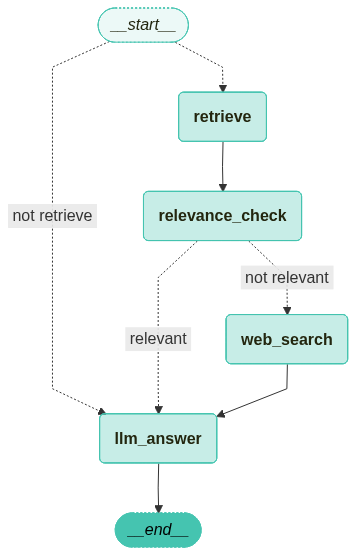

In [22]:
from langchain_teddynote.graphs import visualize_graph
visualize_graph(app)

<h3>그래프 실행</h3>

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = GraphState(question="2025년 미국 대통령 당선인이 누구야?")

invoke_graph(app, inputs, config, node_names=["llm_answer"])

==============retrieve Node============
==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no
["<document><title>[이슈] 2025년 다시 돌아온 트럼프…미국은 다시 위대해 ... - YouTube</title><url>https://www.youtube.com/watch?v=pg7dEPLDnTw</url><content>2025년에 들어서기 직전의 미국 대통령 선거, 미국의 선택은 도널드 트럼프였습니다. '미국을 다시 위대하게'라는 슬로건으로 선거 운동을 한 트럼프</content></document>", "<document><title>[2024 美대선] 트럼프, 2025년 1월 공식 취임까지 어떤 절차 밟을까</title><url>https://v.daum.net/v/23HD0LZwBi</url><content>11·5 미국 대선에서 공화당 대통령 후보인 도널드 트럼프 전 대통령이 당선되며 오는 2025년 1월 20일 제47대 대통령 취임식까지 어떤 절차를 거치는지 관심이 쏠린다. 도널드 트럼프 전 대통령 ⓒAP=연합뉴스. 도널드 트럼프 전 대통령 ⓒAP=연합뉴스. 11·5 미국 대선에서 공화당 대통령 후보인 도널드 트럼프 전 대통령이 당선되며 오는 2025년 1월 20일 제47대 대통령 취임식까지 어떤 절차를 거치는지 관심이 쏠린다. 각 주에서 개표 결과가 확정되면 12월 11일 주별로 배정된 선거인단 수에 맞춰 선거인단 명부가 확정된다. 도널드 트럼프 전 미국 대통령이 지난 1월 21일(현지시간) 미국 뉴햄프셔주 로체스터에서 선거 유세를 펼치고 있다. 도널드 트럼프 전 미국 대통령이 지난 1월 21일(현지시간) 미국 뉴햄프셔주 로체스터에서 선거 유세를 펼치고 있다. 선거인단 투표 결과는 12월 25일까지 연방 의회로 보내지고, 이듬해 1월 6일

In [24]:
from langchain_teddynote.messages import stream_graph
stream_graph(app, inputs, config)


🔄 Node: __start__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"need_retrieve": "yes"}==============retrieve Node============

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score": "no"}==== [RELEVANCE CHECK] ====
no
["<document><title>[이슈] 2025년 다시 돌아온 트럼프…미국은 다시 위대해 ... - YouTube</title><url>https://www.youtube.com/watch?v=pg7dEPLDnTw</url><content>2025년에 들어서기 직전의 미국 대통령 선거, 미국의 선택은 도널드 트럼프였습니다. '미국을 다시 위대하게'라는 슬로건으로 선거 운동을 한 트럼프</content></document>", "<document><title>[2024 美대선] 트럼프, 2025년 1월 공식 취임까지 어떤 절차 밟을까</title><url>https://v.daum.net/v/23HD0LZwBi</url><content>11·5 미국 대선에서 공화당 대통령 후보인 도널드 트럼프 전 대통령이 당선되며 오는 2025년 1월 20일 제47대 대통령 취임식까지 어떤 절차를 거치는지 관심이 쏠린다. 도널드 트럼프 전 대통령 ⓒAP=연합뉴스. 도널드 트럼프 전 대통령 ⓒAP=연합뉴스. 11·5 미국 대선에서 공화당 대통령 후보인 도널드 트럼프 전 대통령이 당선되며 오는 2025년 1월 20일 제47대 대통령 취임식까지 어떤 절차를 거치는지 관심이 쏠린다. 각 주에서 개표 결과가 확정되면 12월 11일 주별로 배정된 선거인단 수에 맞춰 선거인단 명부가 확정된다. 도널드 트럼프 전 미국 대통령이 지난 1월 21일(현지시간) 미국 뉴햄프셔주 로체스터에서 선거 유세를 펼치고 있다. 도널드 트럼프 전 미국

In [17]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 2025년 미국 대통령 당선인이 누구야?
Answer:
트럼프 전 대통령이 당선되었습니다.
